In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
flights = pd.read_csv(r"C:\Users\jdami\OneDrive\Documents\GitHub\Datathon-vivaaero\train_test\Filghts_train_test.csv")
sales = pd.read_csv(r"C:\Users\jdami\OneDrive\Documents\GitHub\Datathon-vivaaero\train_test\Sales_train_test.csv")
vuelos = flights.merge(sales.drop(columns='TotalSales'), on = 'Flight_ID', how = 'left')

# Asegúrate de que la columna de fecha está en formato datetime
vuelos['STD'] = pd.to_datetime(vuelos['STD'])
vuelos['STA'] = pd.to_datetime(vuelos['STA'])

vuelos['Day_of_Week'] = vuelos['STD'].dt.dayofweek
vuelos['Month'] = pd.to_datetime(vuelos['STD']).dt.month

Q1 = vuelos['Quantity'].quantile(0.25)
Q3 = vuelos['Quantity'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar outliers
vuelos_filtrados = vuelos[(vuelos['Quantity'] >= lower_bound) & (vuelos['Quantity'] <= upper_bound)]

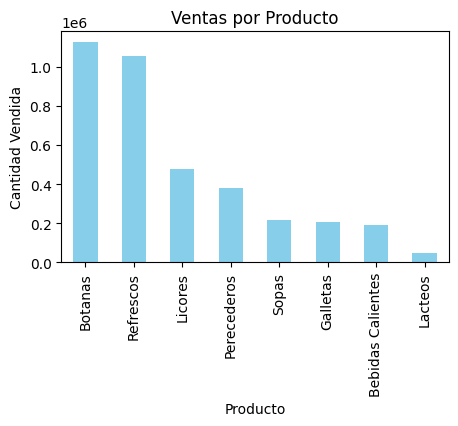

In [3]:
# Agrupar por producto y sumar las cantidades vendidas
ventas_por_tipo_producto = vuelos_filtrados.groupby('ProductType')['Quantity'].sum()

# Ordenar los resultados para ver los productos más vendidos
ventas_por_tipo_producto_sorted = ventas_por_tipo_producto.sort_values(ascending=False)

# Gráfico de barras de las ventas por producto
plt.figure(figsize=(5, 3))
ventas_por_tipo_producto_sorted.plot(kind='bar', color='skyblue')
plt.title('Ventas por Producto')
plt.xlabel('Producto')
plt.ylabel('Cantidad Vendida')
plt.xticks(rotation=90)
plt.show()


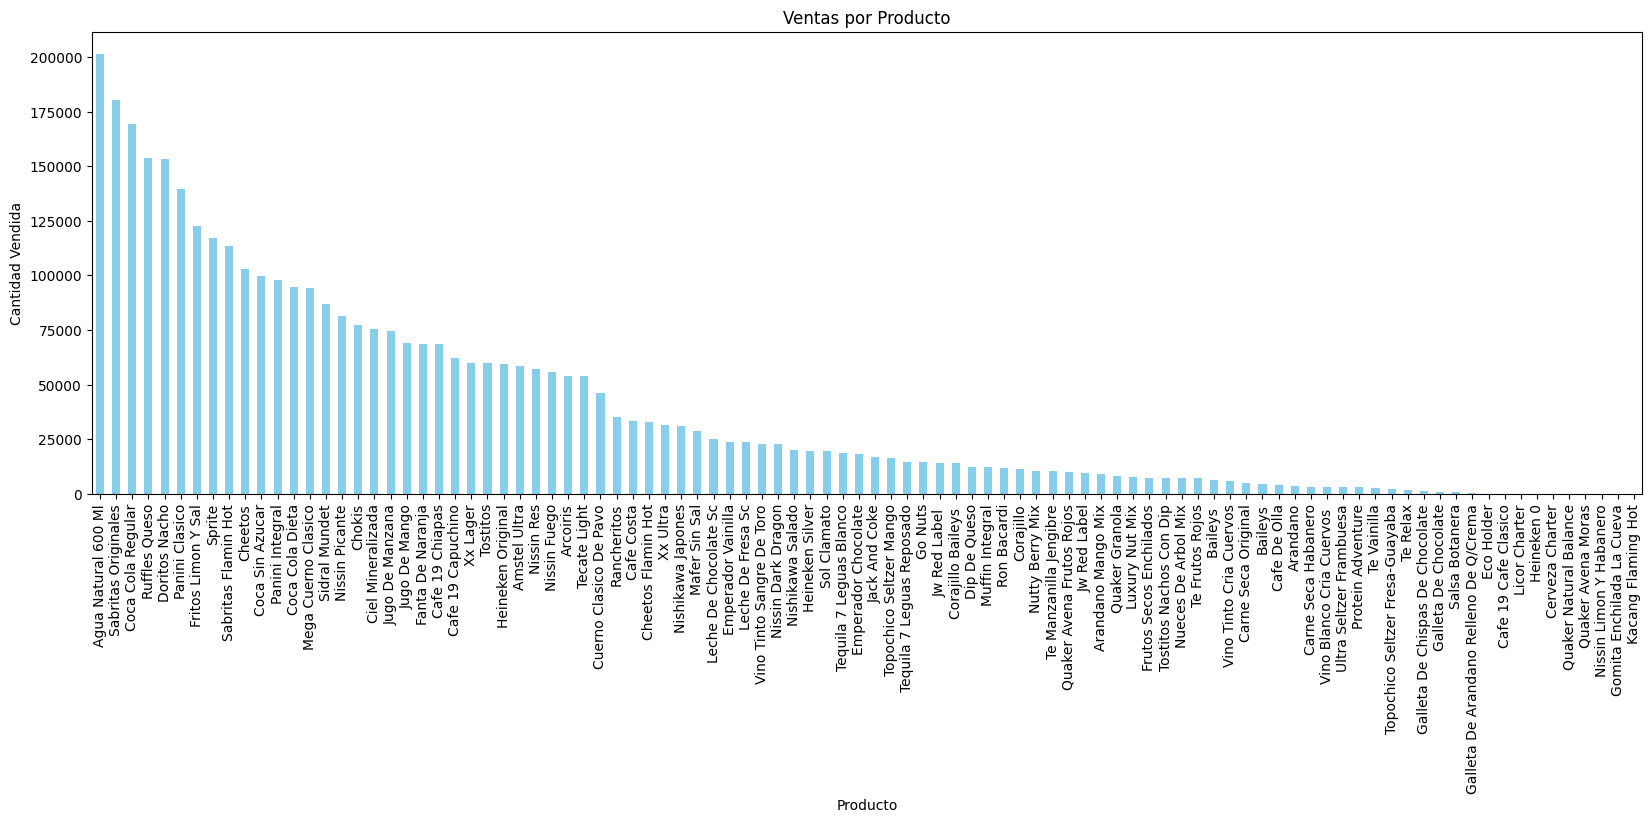

In [4]:
# Agrupar por producto y sumar las cantidades vendidas
ventas_por_producto = vuelos_filtrados.groupby('ProductName')['Quantity'].sum()

# Ordenar los resultados para ver los productos más vendidos
ventas_por_producto_sorted = ventas_por_producto.sort_values(ascending=False)

# Gráfico de barras de las ventas por producto
plt.figure(figsize=(20, 6))
ventas_por_producto_sorted.plot(kind='bar', color='skyblue')
plt.title('Ventas por Producto')
plt.xlabel('Producto')
plt.ylabel('Cantidad Vendida')
plt.xticks(rotation=90)
plt.show()

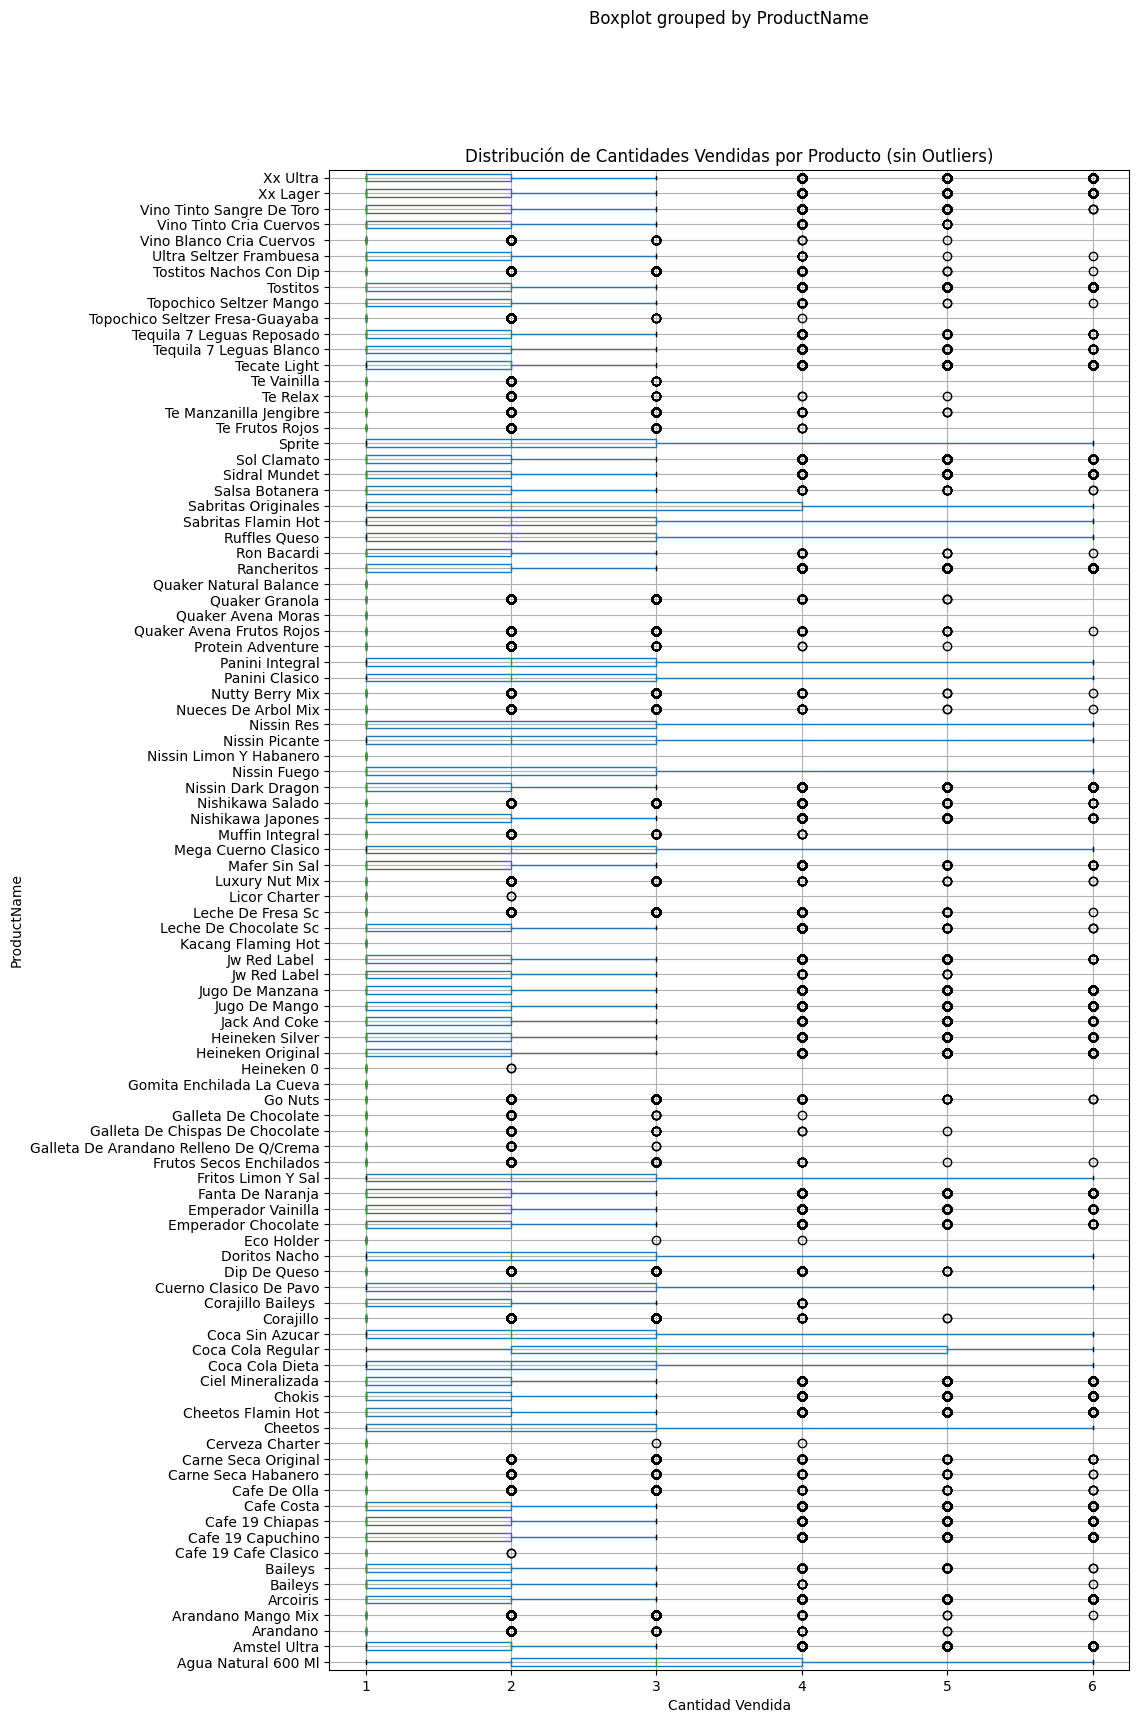

In [5]:
vuelos_filtrados.boxplot(column='Quantity', by='ProductName', vert=False, figsize=(10,20))
plt.title('Distribución de Cantidades Vendidas por Producto (sin Outliers)')
plt.xlabel('Cantidad Vendida')
plt.show()

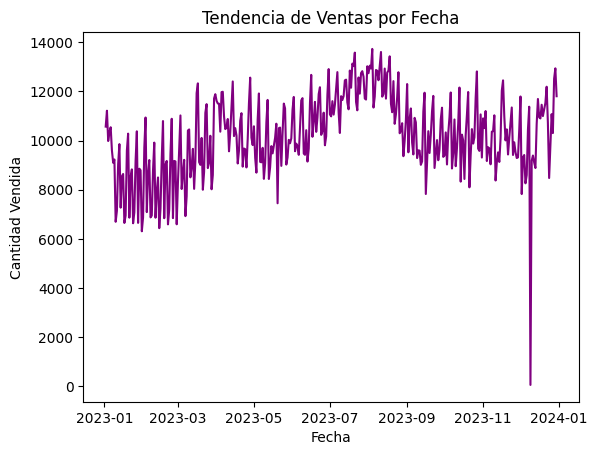

In [6]:
# Agrupar por fecha y sumar las ventas
ventas_por_fecha = vuelos_filtrados.groupby(vuelos_filtrados['STD'].dt.date)['Quantity'].sum()

# Gráfico de series temporales de las ventas
ventas_por_fecha.plot(kind='line', color='purple')
plt.title('Tendencia de Ventas por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.show()


In [ ]:
# Asumiendo que 'vuelos' ya está cargado y preparado correctamente
X = vuelos.set_index('Flight_ID')[['Capacity', 'Month', 'Day_of_Week', 'Hour of Day', 'Duration', 'Destination_Type', 'DepartureStation', 'ArrivalStation', 'Aeronave',  'Ocupancia']]
y = pd.pivot_table(vuelos, index='Flight_ID', columns='ProductName', values='Quantity', fill_value=0)

# Codificar variables categóricas usando get_dummies
X = pd.get_dummies(X, columns=['Destination_Type', 'DepartureStation', 'ArrivalStation', 'Aeronave'])

# Asegurarse de que ambos X e y tienen exactamente los mismos índices
X = X.loc[y.index]
y = y.loc[X.index]

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo MultiOutput
multioutput_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=1, random_state=42, n_jobs=-1))
multioutput_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = multioutput_model.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

r2 = r2_score(y_test, y_pred)
print("R^2:", r2)

In [ ]:
# Supongamos que `y_test.columns` tiene los nombres de los productos correspondientes
pred_df = pd.DataFrame(np.round(y_pred), columns=y_test.columns, index=y_test.index)
pred_df

In [55]:
test_f_data = pd.read_csv(r"C:\Users\jdami\OneDrive\Documents\GitHub\Datathon-vivaaero\pred\Filghts_pred.csv")
test_s_data = pd.read_csv(r"C:\Users\jdami\OneDrive\Documents\GitHub\Datathon-vivaaero\pred\Sales_pred.csv")

In [56]:
test_vuelos = test_f_data.merge(test_s_data, on = 'Flight_ID', how = 'left')
test_vuelos['Ocupancia'] = test_vuelos['Passengers'] / test_vuelos['Capacity']

test_vuelos['STD'] = pd.to_datetime(test_vuelos['STD'])
test_vuelos['STA'] = pd.to_datetime(test_vuelos['STA'])
test_vuelos['Month'] = test_vuelos['STD'].dt.month
test_vuelos['Day_of_Week'] = test_vuelos['STD'].dt.dayofweek


In [57]:
X = test_vuelos.set_index('Flight_ID')[['Month', 'Day_of_Week', 'Hour of Day', 'Duration', 'Destination_Type', 'Ocupancia']]
y = pd.pivot_table(test_vuelos, index='Flight_ID', columns='ProductName', values='Quantity', fill_value=0)

X = pd.get_dummies(X, columns=['Destination_Type'])

X = X.loc[y.index]
y = y.loc[X.index]

In [62]:
predicted_quantities = multioutput_model.predict(X)

c:\Users\jdami\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\jdami\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\jdami\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\jdami\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

In [63]:

# Convertir las predicciones a un DataFrame para facilitar la manipulación o visualización
predicted_quantities

array([[ 4.59532166e+00,  2.69828796e-01, -2.81972885e-02, ...,
         6.00814819e-04,  5.10478973e-01,  1.09596252e-01],
       [ 4.59532166e+00,  2.69828796e-01, -2.81972885e-02, ...,
         6.00814819e-04,  5.10478973e-01,  1.09596252e-01],
       [ 4.59532166e+00,  2.69828796e-01, -2.81972885e-02, ...,
         6.00814819e-04,  5.10478973e-01,  1.09596252e-01],
       ...,
       [ 3.11387634e+00,  3.89942408e-01, -3.54595184e-02, ...,
         3.60984802e-02,  5.43566704e-01,  1.90536499e-01],
       [ 3.11387634e+00,  3.89942408e-01, -3.54595184e-02, ...,
         3.60984802e-02,  5.43566704e-01,  1.90536499e-01],
       [ 3.11387634e+00,  3.89942408e-01, -3.54595184e-02, ...,
         3.60984802e-02,  5.43566704e-01,  1.90536499e-01]])